<a href="https://colab.research.google.com/github/elisasanzani/Software_and_Computing_Project/blob/main/PNet_RMC_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Particle Net Lite Custom GD-CNN**

In [4]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

Data is downloaded in one go from Dropbox for simplicity. 
Unzipped version available in [main/data-PNet](ADD LINK)

In [6]:
!wget https://www.dropbox.com/s/ad08fg4c132nzvo/keras_input.zip?dl=0 -O keras_input.zip
!unzip keras_input.zip

data_folder = "."

--2022-08-12 19:46:21--  https://www.dropbox.com/s/ad08fg4c132nzvo/keras_input.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ad08fg4c132nzvo/keras_input.zip [following]
--2022-08-12 19:46:21--  https://www.dropbox.com/s/raw/ad08fg4c132nzvo/keras_input.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4d5706861efac4b3aa99e4a911.dl.dropboxusercontent.com/cd/0/inline/Bq7N3kAaLWLOhB9BsWY_mqkHDWl3RUuVGp_1x5gbOpo20EpwUhSSMnyCGZ7XHOWDWpYtls7SLUVbxqcvXg86wqJGXoQQrXExuL1OT4KmzXWFEufgzummwfKSCCVJlJSeyEwXiTLPy5EpUx-fPTaF422SfCprErMmDSZs21bLucGA8Q/file# [following]
--2022-08-12 19:46:22--  https://uc4d5706861efac4b3aa99e4a911.dl.dropboxusercontent.com/cd/0/inline/Bq7N3kAaLWLOhB9BsWY_mqkHDWl3RUuVGp_1x5gbOpo20EpwUhS

The three datasets are saved as dictionaries with 4 components:
<u1 type="circle">
<li>"points": Point Cloud (xy coordinates of each hit of a cluster) - 50 maximum hits </li>
<li>"features": Energy and Time of each hit of a cluster - 50 maximum hits</li>
<li>"mask": Mask to distinguish real hits (filled with 1, the others are filled with 0) in a cluster</li>
<li>"summary": Energy, Time, Centroid Radius, and Number of active cells for a cluster</li>
<br>
The MC data has been filtered with ROOT
using two pre-selection cuts:
E > 50 MeV  &&  R > 480 mm <br>
The cuts are necessary because in the low-energy and low-radius region the 
background due to the beam is too high


In [7]:
name_map = {"points": "xy", "features": "et", "mask": "mask", "summary": "etrn"}

signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

# Data Visualization
Hits on the calorimeter for N = 10 random events per each event type are shown

10


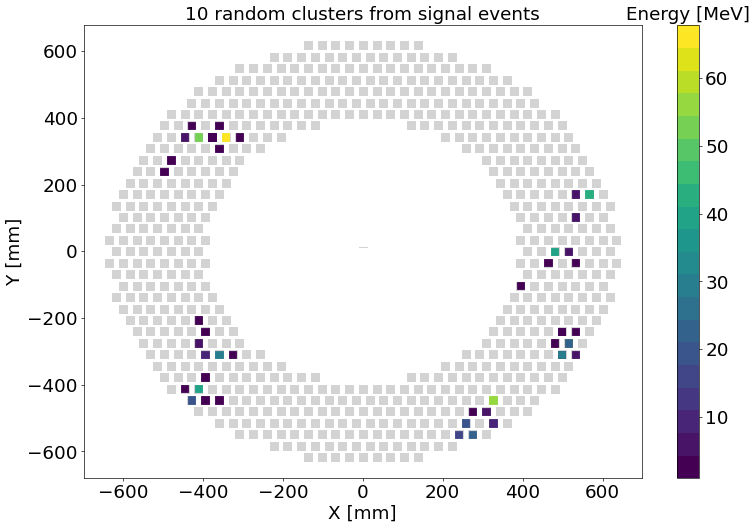

10


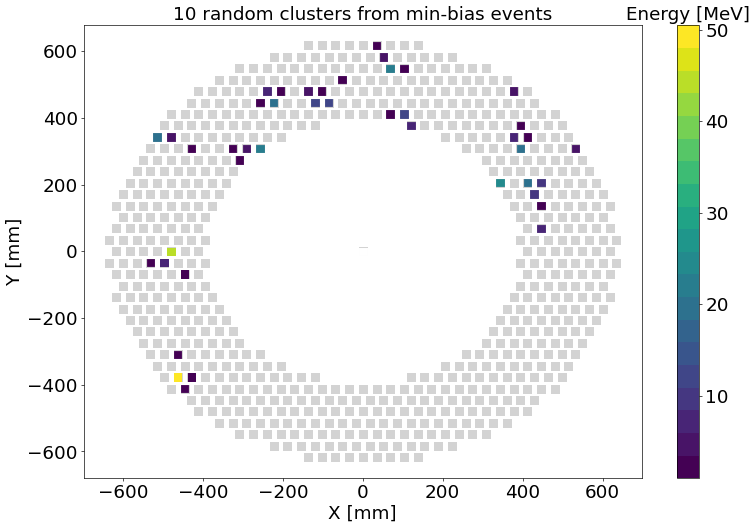

10


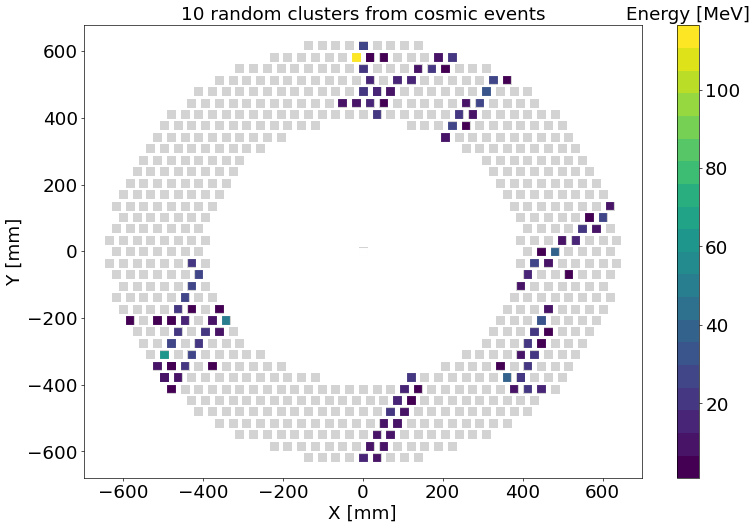

In [8]:
channels = [signal, mnbs, cosmics]
ch_names = ["signal", "min-bias", "cosmic"]

cmap = plt.get_cmap('viridis', 20)
cmap.set_under('white')

N = 10

for ch, name in zip(channels, ch_names):
  evs = np.random.randint(0, high=len(ch["points"]), size=N, dtype=int)
  print(len(evs))
  plt.figure(figsize=(15, 10), dpi=60)
  plt.scatter(cosmics["points"][:, :, 0], cosmics["points"][:, :, 1], marker="s", s=80, color="lightgrey")
  arr_xy = ch["points"][evs]
  x, y = arr_xy[:, :, 0], arr_xy[:, :, 1]
  e = ch["features"][evs][:, :, 0]
  plt.scatter(x, y, c=e, cmap=cmap, vmin=1, marker="s", s=80)
  plt.title(f"{N} random clusters from {name} events", fontsize=22)
  plt.xlabel("X [mm]", fontsize=22)
  plt.ylabel("Y [mm]", fontsize=22)
  plt.xticks(fontsize=22)
  plt.yticks(fontsize=22)
  clb = plt.colorbar()
  clb.ax.set_title('Energy [MeV]',fontsize=22)
  clb.ax.tick_params(labelsize=22)
  plt.show()

# Training
The MC samples are weighted to match the expected ratios in one injection cycle. 


Real expected cluster on upstream disk in one injection cycle (1.33s):<br>
RMC: 330 <br>
MNBS: 1.3M <br>
cosmics: 4 <br> <br>

MC cluster on upstream disk:<br>
RMC: 150k<br>
MNBS: 1.05M<br>
cosmics: 53k




In [9]:
signal_weight = 330/150e3 * 100
mnbs_weight = 0.24 * 100
cosmics_weight = 4/53e3 * 100

print(end="")

The samples are merged into a unique dataset, which is then shuffled, saving also labels and weights


In [10]:
S =  signal["mask"].shape[0] 
F =    mnbs["mask"].shape[0] 
C = cosmics["mask"].shape[0]

N = S + F + C

p = np.random.permutation(N) 

In [12]:
data = {key: np.concatenate( (signal[key], mnbs[key], cosmics[key]) )[p] for key in name_map}

label_list = [1, 0, 0]
entries_list = [S, F, C]
weight_list = [signal_weight, mnbs_weight, cosmics_weight]

print(f"- Entries for signal, mnbs and cosmics:{entries_list}")
print(f"- Weigths for signal, mnbs and cosmics:{weight_list}")

label = np.concatenate( 
    [ np.ones((e))*l for e, l in zip(entries_list,  label_list) ]
)[p]

sample_weight = np.concatenate( 
    [ np.ones((e))*w for e, w in zip(entries_list, weight_list) ]
)[p]


- Entries for signal, mnbs and cosmics:[41372, 1132, 41598]
- Weigths for signal, mnbs and cosmics:[0.22, 24.0, 0.007547169811320755]


Data is normalized to help the training

In [13]:
from sklearn.preprocessing import StandardScaler
import copy
scaler = StandardScaler()

virgin_data = copy.deepcopy(data)

for key in ["points", "features"]:
  data[key][data["mask"].reshape(N, 50)] = scaler.fit_transform(data[key][data["mask"].reshape(N, 50)])

data["summary"] = scaler.fit_transform(data["summary"])

The dataset is divided in training, test and validation with a ratio 7:2:1

In [14]:
train_data  = {key: data[key][int(N*0.0) : int(N*0.7)] for key in name_map}
test_data   = {key: data[key][int(N*0.7) : int(N*0.9)] for key in name_map}
val_data    = {key: data[key][int(N*0.9) : int(N*1.0)] for key in name_map}

train_label = label[int(N*0.0) : int(N*0.7)]
test_label  = label[int(N*0.7) : int(N*0.9)]
val_label   = label[int(N*0.9) : int(N*1.0)]

train_weight = sample_weight[int(N*0.0) : int(N*0.7)]
test_weight  = sample_weight[int(N*0.7) : int(N*0.9)]
val_weight   = sample_weight[int(N*0.9) : int(N*1.0)]

The custom model is imported from the GitHub repo (working on it)